# Community Analysis
> "This section will investigate communities in the network and further perform text and sentiment analysis."

- toc: false
- branch: master
- badges: true
- comments: true
- categories: [community, network, text analysis, sentiment]
- hide: true
- search_exclude: false
- metadata_key1: metadata_value1
- metadata_key2: metadata_value2

In [1]:
#hide
import pandas as pd 
import numpy as np 
import networkx as nx
import matplotlib.pyplot as plt 
import urllib
import json
import re 
import os 
from imdb import IMDb
import contextlib
import powerlaw

from fa2 import ForceAtlas2
import powerlaw
from wordcloud import WordCloud
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import requests

import nltk
from nltk import FreqDist
from nltk.text import TextCollection
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

from community import community_louvain
import plotly.express as px

from itertools import groupby
#Download NLTK stuff for lemmatizer and tokenizer:
nltk.download('punkt')
nltk.download('wordnet')


#Set stuff for nice formmatting of plots: 
import seaborn as sns
sns.set()
%matplotlib inline
import itertools
nltk.download("stopwords")
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize
import string
#hide 
char_list = [f.split('.txt')[0] for f in os.listdir("../data/got_cleaned/")]

char_names = []
for char in char_list:
    char = char.lower()
    char_names.append(char.replace("_"," "))
    char_names.extend(char.split('_'))
stop_words = set(stopwords.words('english') + list(string.punctuation) + list(char_names))
def clean_text(txt, charlist):    
    txt = txt.lower()

    word_tokens = wordpunct_tokenize(txt)
    
    filtered_sentence = [w for w in word_tokens if not w.lower() in stop_words]


    wnlet = WordNetLemmatizer()
    words = [wnlet.lemmatize(w) for w in filtered_sentence] 
    return words


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\nicol\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


This section contains three parts: the first part we will explain how we generate the communities and investigate the basics of the communities. Next we will investigate the language used by these communities, namely find the words with the highest TF-IDF. Lastly, we are going to investigate the sentiment of these communities. 


<h1 align="center">Community detection</h1>  



In this section, we will find communities in the Game of Thrones network. These communities are identified using the Louvain Algorithm. Further explanation of the Lovain Algorithm can be found in the [Explainer Notebook](https://mikkelmathiasen23.github.io/GameOfThrones_Network/Explainer_Notebook/). In total, six communities are identified with a modularity value of 0.31. Below, some exploratory analysis can be seen of these 6 communities using the character attributes religion, culture and allegiance. 

In [2]:
#hide
G = nx.read_gpickle("../data/got_G.gpickle")
#Generate partitioning into communities using louvain method:
G_unDi = G.to_undirected()
partition = community_louvain.best_partition(G_unDi, randomize=False)

#Create a dict containing the communities and the characters in the community:
link_partition = {c: [character for character, community in partition.items() if community == c] 
                    for c in set(partition.values())}

print(f'Number of communities in network: {len(link_partition)}')
print(f'Modularity of partition: {community_louvain.modularity(partition,G_unDi)}')

Number of communities in network: 6
Modularity of partition: 0.31883935952117176


From the figure below the size of each community is presented. From this it is clear that *Community 1* is the largest community. Whereas *Community 0*  is the smallest. 

In [3]:
#hide_input 
dict_list = {}
dict_list["Number of members in community"] = [len(com) for com in link_partition.values()]
dict_list["Community"] = list(link_partition.keys())

df = pd.DataFrame(dict_list)
fig = px.bar(df, x="Community",y  ='Number of members in community', title = "Distribution plot of community sizes")
fig.show()

#Sort and find the 5 largest communities:
top5_com = sorted(link_partition, key = lambda i: len(link_partition[i]),reverse = True)[:2]


Next, we will investigate what religions, cultures and allegiances each community contains, as this can help us understand what the Louvain algorithm have chosen in order to split the characters into the different communities. We will start out by looking into religion.

In [4]:
#hide
dfs = {}
figs = {}
attributes = ["religion", "appearances", "culture", "allegiance"]


attributes_dict = {}
for attribute in attributes: 
    attributes_dict[attribute] = nx.get_node_attributes(G, attribute)
    
    com_dict  = {}
    att = []
    counter = []
    com_ = []
    for com, char_list in link_partition.items():
        
        tmp = [attributes_dict[attribute][char] for char in char_list]
        tmp2 = [[tmp.count(att),att]for att in set(tmp) if att != ""]#
        for l1 in tmp2:
            if l1[1] == "":
                l1[1] = "Uknown"
            att.append(l1[1])
            counter.append(l1[0])
        com_.extend([com]*len(tmp2))
        
    dfs[attribute.capitalize()] = pd.DataFrame({"Community" : com_,
                                                attribute.capitalize() : att,
                                                "Count" : counter}).fillna(0)
    figs[attribute.capitalize()] = px.bar(dfs[attribute.capitalize()], 
                                            x="Community", y="Count", color=attribute.capitalize(), title="{} distribution in communities".format(attribute.capitalize()),
                                            width = 900, height = 375)
        

In [5]:
#hide 
count_rel,count_cul,count_alle = 0,0,0
for rel in figs['Religion'].data:
    count_rel += np.sum(rel['y'])
for rel in figs['Culture'].data:
    count_cul += np.sum(rel['y'])
for rel in figs['Allegiance'].data:
    count_alle += np.sum(rel['y'])
count_rel,count_cul,count_alle

(162, 133, 139)

In [6]:
#hide_input
figs['Religion'].show()

From the above we can notice that *Community 0* contains equal parts of characters being part of Faith of the Seven religion and Drowned God, whereas *Community 1* mainly contain characters being part of Faith of the Seven. 

*Community 0* could therefore be expected to contain people from the Iron Island and as well from Kings Landing, whereas *Community 1* contains primarily people from Faith of the Seven, and 1 from the Old Gods of the Forest, this could maybe be people being from House Lannister and Sansa Stark as these characters are very well connected in large parts of the story. 

Next, in *Community 2* the religions are a mix of the Great Stallion, the Old Gods of the Forest, the Faith of the Seven and Ghiscari. This could be due to the characters surrounding Daenarys Targaryen, as her group are a rather mixed group. 

The next three communities are also rather mixed, and could represent multiple groups of characters thus being rather complicated to decrypt. 

In [7]:
#hide_input
figs['Allegiance'].show()

From the figure above it can be seen that the communities are very mixed when it comes to allegiance, which would be expected as the Game Of Thrones universe contains a lot of different allegiances, and these are mixing up together. Eg. the people from the North are part of many different allegiances, but are grouping together when needed for eg. war. 

One could see that the largest allegiance in community 1 are House Lannister, but also contains Petyr Baelish, Kingsguard, Sparrows, House Clegane etc. This community appears to describe the important people of Kings Landing. 

Community 2 is described by House Targaryen, Second Sons, Unsullied, Drogo and could describe the group sorounding Daenarys Targaryen.

Community 3 is described by House Umber, Free Folk, Night's Watch and White Walkers, maybe this community describes the people interacting at the Wall and the land around it. This could explain this group of allegiances. 

In [8]:
#hide_input
figs['Culture'].show()


Lastly, we are looking into what culture each community contains. Here it can be seen that the Andals are the largest in Community 1, 3, and 5. This would be expected as this is the largeset cultural group in Game Of Thrones. 

Community 2 contains large group of Dothraki people, and this again underlines that community 2 could be the group of characters surrounding Daenarys. 

Similarly, we see that community 3 contains Free Folk, Northmen, White Walkers, Children of the Forest, which could indicate the people at the Wall and beyond. 

<h1 align = "center">Community character exploration </h1>

In this section we will visualize each of the communities in the same way that it was done in [Game Of Thrones Network Analysis](https://mikkelmathiasen23.github.io/GameOfThrones_Network/GameOfThronesNetwork/) in an attempt to understand how the communities have been detected. From analysis in the above part we did encounter some patterns that could explain why the communities was created as they are. We will now dig into what characters are present and how they are connected. 

We encourage you to use the functionalities of this app to investigate how the characters interact in each community in which attributes that are present. 

<iframe src="https://gameofthronescommunity.herokuapp.com/" width ="1000" height = "1200"> </iframe>

<h1 align="center">TF-IDF and wordclouds</h1>  

As in the [Text Analysis section](https://mikkelmathiasen23.github.io/GameOfThrones_Network/textanalysis/), we will compute TF-IDF for each community, which can help us investigate the properties of the different communities. 

As each community consist of different characters, and we know which words each character are described by from its character page on the [Wiki-page](https://gameofthrones.fandom.com/wiki/Game_of_Thrones_Wiki). From this we can thereby first compute the TF-for each community, and afterwards compute IDF for all the words used across the communities. From these computations we can now compute the TF-IDF. To see the full computations of the TF-IDF these can be found in the [Explainer Notebook](https://mikkelmathiasen23.github.io/GameOfThrones_Network/Explainer_Notebook/).

In [9]:
#hide
char_pages = {}
characters = [f.split('.txt')[0] for f in os.listdir("../data/got_cleaned/")]

for char in characters:
    name = char.replace('_', ' ')
    with open('../data/got_cleaned/'+char+".txt", "r",encoding = "utf-8") as text_file:
            txt = text_file.readlines()
    char_pages[name] = clean_text(" ".join(txt),characters)


l_dict_com, tc_dict_com = {}, {}
for com, characters in link_partition.items():
    words = []
    for char in characters:
        try:
            words.extend(char_pages[char.replace("_", " ")])
        except:
            continue
    
    l_dict_com[com] = len(words)
    #Compute TC for the community words:
    tc_dict_com[com] = FreqDist(words)

# # Find all unique words
unique_words = set(list(itertools.chain(*tc_dict_com.values())))

# Calculate idf
idf_com = {word: 
            #Find in how many documents that each word is present:
            np.log(len(link_partition.keys()) / sum([tf[word] > 0 for k, tf in tc_dict_com.items()])) 
            #Iterate through unique words:
            for word in unique_words
      }
#Create dict for tf-idf values:
tf_idf_com = {}

#Iterate through communities:
for com in link_partition.keys():
    tf_idf = {}
    #Iterate through each word in each community:
    for word, tf_value in tc_dict_com[com].items():
        #Extract IDF
        idf_value = idf_com[word]
        #Compute TF-IDF
        tf_idf[word] = idf_value*tf_value/l_dict_com[com]
    tf_idf_com[com] = tf_idf    


The computed TF-IDF are used to size the words when visualizing the words describing each community. The results of the analysis are presented in the figure below. 

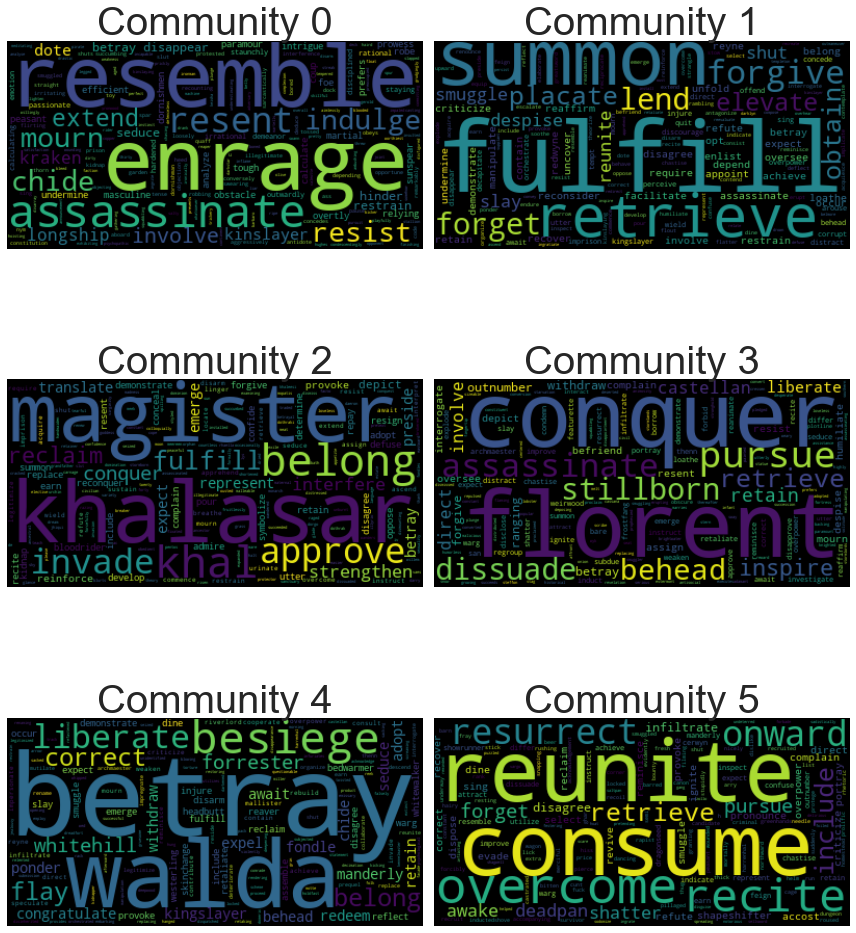

In [10]:
#hide_input
selected_com = [0,1,2,3,4,5]
names = ["Community " + str(com) for com in selected_com]
#hide_input
def plot_wordcloud(races,tc_idf_race, name=None):
    plt.figure(figsize = (12,15))
    for i,race in enumerate(races):
        word_list= []
        for word, value in tc_idf_race[race].items():
            word_list.append((word+' ')*int(np.ceil(value)))
        word_list = " ".join(word_list)
        wc = WordCloud(collocations=False).generate(word_list)

        plt.subplot(3,2,i+1)
        plt.imshow(wc, interpolation='bilinear')
        if name is not None:
            race = name[i]
        plt.title(race, fontsize = 40)
        plt.axis("off")
    plt.tight_layout()
    plt.show()
plot_wordcloud(selected_com, tf_idf_com, names )


We notice that the words are very descriptive. If we use community 2 as an example we can see that these words match very well with the expectation that this group describes the people around Daenerys Targaryen. This includes khal, khalasar, invade, reclaim, conquer as she starts out with being wife of Khal Drogo and being part of his khalasar. Later she invades multiple cities and conquer a large part of the Game Of Thrones universe. Further she tries to reclaim the Iron Throne. 

The same pattern of words describing the community can be seen in the other wordclouds. 

<h1 align="center">Sentiment analysis</h1>  

This part will dive into the sentiment of each community, this will be based on character dialogoues instead of the wiki-pages as used in the previous part. This is done as it is expected that the dialogoue of each character better resembles the character's mood rather than a wiki-page describing the character. 

As in the [Text Analysis section](https://mikkelmathiasen23.github.io/GameOfThrones_Network/textanalysis/) this will be based on LabMT and VADER sentiment methods.
 

In [11]:
#hide
LabMT = pd.read_table('../data/labMIT-1.0.txt', delimiter="\t")
#Convert LabMT to a dictionary:
LabMT_dict = {word : happiness_score for word,happiness_score in zip(LabMT['word'], LabMT['happiness_average']) }

#Load VADER wordlist:
analyzer = SentimentIntensityAnalyzer()

#Functions to compute LabMT and VADER sentiment values of tokens:
lemmatizer = WordNetLemmatizer() 
def sentiment_LabMT(tokens):
    #Extract tokens that are present in LabMT:
    tokens_LabMT = [token for token in tokens if token in LabMT_dict.keys()]
    #Extract sentiment values of tokens:
    happiness_LabMT = [LabMT_dict[token] for token in tokens_LabMT]

    #Return mean values of sentiments:
    return  np.mean(happiness_LabMT)

def sentiment_VADER(tokens):
    
    happiness_VADER = [analyzer.polarity_scores(sentence)['compound'] for sentence in tokens]
    return np.mean(happiness_VADER)

In [12]:
#hide
import warnings
### GET DIAGLOGUE FOR EACH CHARACTER:
resp = requests.get("https://raw.githubusercontent.com/jeffreylancaster/game-of-thrones/master/data/script-bag-of-words.json")

diag = json.loads(resp.text)

char_diag = {}
for element in diag:
    episode = element['episodeNum']
    season = element['seasonNum']
    title = element['episodeTitle']
    text = element['text']
    for textObj in text:
        if textObj['name'] in char_diag:
            char_diag[textObj['name']].append(textObj['text'])
        else:
            char_diag[textObj['name']] = [textObj['text']]

tokens_LabMT = {char : [lemmatizer.lemmatize(word) for word in word_tokenize(" ".join(text).lower())] for char, text in char_diag.items()}
tokens_VADER = char_diag    

files = os.listdir("../data/got/")
char_list = [file.split('.txt')[0] for file in files]

#Suprress warnings:
warnings.filterwarnings("ignore")
#Compute sentiment for each character:
char_sentiment_LabMT = {char :sentiment_LabMT(tokens_values) for char, tokens_values in tokens_LabMT.items() if char.replace(" ", "_") in char_list}
char_sentiment_VADER = {char :sentiment_VADER(tokens_values) for char, tokens_values in tokens_VADER.items() if char.replace(" ", "_") in char_list}

In [13]:
#hide
com_sentiment_VADER = {com : 
                        #Compute sentiment for community:
                        np.nanmean([char_sentiment_VADER[char.replace("_", " ")] for char in characters if char.replace("_"," ") in char_sentiment_VADER.keys()]) 
                    #Iterate through each community:
                    for com, characters in link_partition.items()}
com_sentiment_LabMT = {com : 
                        #Compute sentiment for community:
                        np.nanmean([char_sentiment_LabMT[char.replace("_", " ")] for char in characters if char.replace("_"," ") in char_sentiment_LabMT.keys()]) 
                    #Iterate through each community:
                    for com, characters in link_partition.items()}
com_sentiment_VADER_sd = {com : 
            np.nanstd([char_sentiment_VADER[char.replace("_"," ")] for char in characters if char.replace("_"," ") in char_sentiment_VADER.keys()]) 
            for com, characters in link_partition.items()}

com_sentiment_LabMT_sd = {com : 
            np.nanstd([char_sentiment_LabMT[char.replace("_"," ")] for char in characters if char.replace("_"," ") in char_sentiment_LabMT.keys()]) 
            for com, characters in link_partition.items()}
#Sort and find top 3 happiest and sadest:
top3_happiest_VADER = sorted(com_sentiment_VADER, key = lambda i: com_sentiment_VADER[i],reverse = True)[:3]
top3_happiest_LabMT = sorted(com_sentiment_LabMT, key = lambda i: com_sentiment_LabMT[i],reverse = True)[:3]

top3_sadest_VADER = sorted(com_sentiment_VADER, key = lambda i: com_sentiment_VADER[i],reverse = False)[:3]
top3_sadest_LabMT = sorted(com_sentiment_LabMT, key = lambda i: com_sentiment_LabMT[i],reverse = False)[:3]


#Convert community number to community name:
print("Top three happiest communities based on VADER: \n",top3_happiest_VADER)
print("Top three happiest communities based on LabMT: \n",top3_happiest_LabMT)

print("Top three sadest communities based on VADER: \n",top3_sadest_VADER)
print("Top three sadest communities based on LabMT: \n",top3_sadest_LabMT)

Top three happiest communities based on VADER: 
 [1, 2, 4]
Top three happiest communities based on LabMT: 
 [0, 1, 4]
Top three sadest communities based on VADER: 
 [3, 5, 0]
Top three sadest communities based on LabMT: 
 [3, 5, 2]


In [14]:
#hide_input
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def plot_VADER_LabMT_scores(char_sentiment_VADER,char_sentiment_LabMT, error_bar = False,
  com_sentiment_VADER_sd=None, com_sentiment_LabMT_sd=None, x_text = "Characters"):
    # Create figure with secondary y-axis
    fig = make_subplots(rows=1, cols=2)#,specs=[[{"secondary_y": True}]])
    # Add traces

    if error_bar:
        fig.add_trace(
            go.Bar(x=[*char_sentiment_LabMT],
            y=list(char_sentiment_LabMT.values()), 
            error_y=dict(
            type='data', # value of error bar given in data coordinates
            array= list(com_sentiment_LabMT_sd.values()),
            visible=True),name="LabMT score"),
            row=1, col=1,
            # secondary_y=False,
        )
        fig.add_trace(
            go.Bar(x=[*char_sentiment_VADER],
            y=list(char_sentiment_VADER.values()), 
            error_y=dict(
            type='data', # value of error bar given in data coordinates
            array= list(com_sentiment_VADER_sd.values()),
            visible=True),
            name="VADER score"),
            row=1, col=2,
            # secondary_y=True,
        )
        
    else:
        fig.add_trace(
            go.Bar(x=[*char_sentiment_LabMT],
            y=list(char_sentiment_LabMT.values()), name="LabMT score"),
            row=1, col=1,
        )

        fig.add_trace(
            go.Bar(x=[*char_sentiment_VADER],
            y=list(char_sentiment_VADER.values()), name="VADER score"),
            row=1, col=2,
        )

    # Add figure title
    fig.update_layout(
        title_text="LabMT and VADER sentiment of communities"
    )

    # Set x-axis title
    fig.update_xaxes(title_text=x_text)
    # Set y-axes titles
    fig.update_yaxes(title_text="<b>LabMT sentiment score</b>", row=1,col = 1)
    fig.update_yaxes(title_text="<b>VADER sentiment score</b> ", row = 1, col = 2)
    return fig

fig = plot_VADER_LabMT_scores(char_sentiment_VADER= com_sentiment_VADER, char_sentiment_LabMT = com_sentiment_LabMT,
                                error_bar = True, com_sentiment_VADER_sd = com_sentiment_VADER_sd,
                                com_sentiment_LabMT_sd= com_sentiment_LabMT_sd, x_text = "Community")
fig.show()

The figure above displays the computed sentiment values for each community based on LabMT and VADER sentiment methods, further the standard deviation are displayed as an error-bar, which can indicate whether a community has a large variation in sentiment values. It can be seen that based on LabMT all communities have almost the same sentiment level and rather small variation, though community 1 has the largest variation, which also can be seen from the VADER sentiments. 

The VADER sentiment appear to have a little larger variation between the communities and as well within each community. 

The VADER score ranges from -4 to +4 and a score of zero indicates that the sentiment is neutral. From this it can be seen that community 2 and three are slightly positive, whereas community 1 are more positive but not happy. Further community 5 appears to be the most sad community. When looking at the LabMT score it ranges from 1.3 to 8.5 where a score of 5 is neutral. Again all the communities are close to being neutral where community 1 is the most happy and community 3 and 5 are the saddest which corresponds with the results from the VADER sentiment scores. 

From the sentiment analysis of each community we find that the most happy community is *Community 1* and *4* whereas the sadest are *Community 5* and *3*.

<h1 align = "center">Subconclusion </h1>

Through this section we have investigated whether the characters are grouped based on an underlying pattern which is not only based on eg. allegiance, culture or religion. Using the Louvain algorithm it was possible to detect six communities, which appears to be described by which characters interact during the series . 

It was possible to detect the main character(s) of each community by the use of network analysis. 
We further investigated these communities through the use of text- and sentiment analysis, and found the words used by each community were well connected with the characters present in this community. The words used by each community helped reveal the underlying structure behind each community. Lastly, the sentiment analysis revealed the mood of each community. 

